In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns
import pandas as pd
import scipy

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


In [2]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    #X = pm.Normal("X", mu=0, sigma=1, shape=n, testval=-1.0 * np.ones_like(mu1))
    
    llk = pm.Potential("llk", two_gaussians(X))
    trace = pm.sample_nf_smc(1000, local_thresh=3, local_step_size=0.5, local_grad=True, nf_local_iter=40,
                             chains=1, frac_validate=0.2, alpha=(0,0), parallel=False, 
                             NBfirstlayer=True, bw_factor=2.0, k_trunc=0.5, pareto=True, 
                             iteration=5, max_line_search=20)
    az_trace = az.from_pymc3(trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000


Number of points we perform additional local exploration around = 0
Number of points we perform additional local exploration around = 58


Stage:   1 Beta: 0.009


Number of points we perform additional local exploration around = 57


Stage:   2 Beta: 0.028


Number of points we perform additional local exploration around = 71


Stage:   3 Beta: 0.068


Number of points we perform additional local exploration around = 49


Stage:   4 Beta: 0.131


Number of points we perform additional local exploration around = 64


Stage:   5 Beta: 0.238


Number of points we perform additional local exploration around = 59


Stage:   6 Beta: 0.386
Stage:   7 Beta: 1.000


In [4]:
nf_evidence = trace.report.log_marginal_likelihood
print(f'NFMC calculated evidence: {nf_evidence[0]}')
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence: -5.514038115282634
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.171  0.486  -0.658    0.639      0.017    0.012     839.0   839.0   
X[1] -0.164  0.472  -0.627    0.642      0.016    0.011     880.0   880.0   
X[2] -0.160  0.481  -0.662    0.599      0.017    0.012     800.0   800.0   
X[3] -0.170  0.483  -0.709    0.598      0.016    0.012     872.0   872.0   

      ess_bulk  ess_tail  r_hat  
X[0]     773.0     988.0    NaN  
X[1]    1001.0     983.0    NaN  
X[2]     775.0     936.0    NaN  
X[3]     947.0     880.0    NaN  


<Figure size 720x480 with 0 Axes>

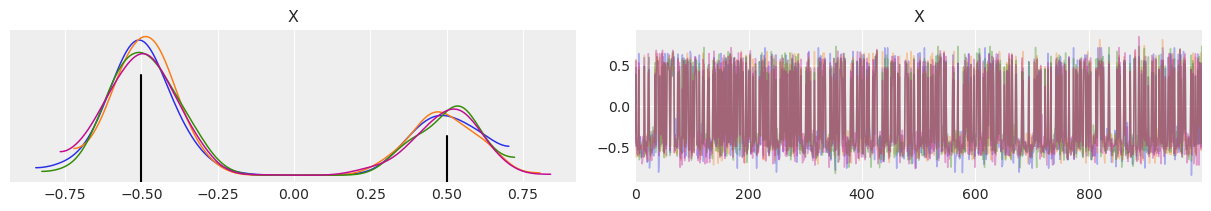

In [5]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

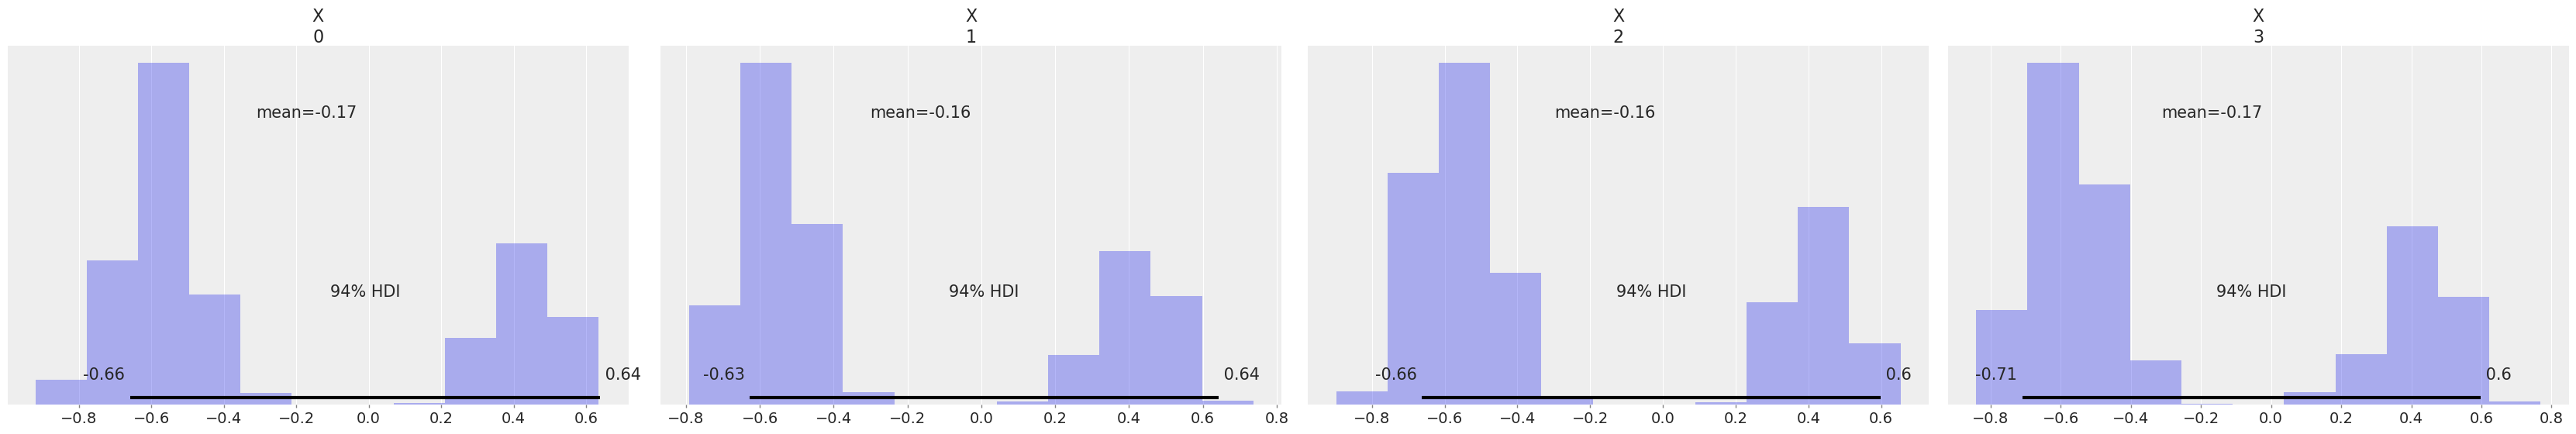

In [6]:
plt.figure()
az.plot_posterior(az_trace, kind='hist')
plt.show()

Let's compare with SMC. 

In [8]:
with model:
    smc_trace = pm.sample_smc(2000)
    az_smc_trace = az.from_pymc3(smc_trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.028
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.142
Stage:   4 Beta: 0.312
Stage:   5 Beta: 0.688
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.066
Stage:   3 Beta: 0.146
Stage:   4 Beta: 0.312
Stage:   5 Beta: 0.645
Stage:   6 Beta: 1.000


In [9]:
smc_evidence = np.exp(smc_trace.report.log_marginal_likelihood)
print(f'SMC calculated evidence: {smc_evidence}')
az_smc_summary = az.summary(az_smc_trace)
print(az_smc_summary)

SMC calculated evidence: [0.00363926 0.00379834]
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.192  0.471  -0.683    0.616      0.007    0.005    4090.0  4072.0   
X[1] -0.195  0.471  -0.674    0.623      0.007    0.005    4070.0  4043.0   
X[2] -0.193  0.471  -0.664    0.624      0.007    0.005    4037.0  3900.0   
X[3] -0.194  0.470  -0.672    0.625      0.007    0.005    4077.0  3756.0   

      ess_bulk  ess_tail  r_hat  
X[0]    4057.0    3924.0    1.0  
X[1]    4023.0    3775.0    1.0  
X[2]    3851.0    3796.0    1.0  
X[3]    4090.0    3812.0    1.0  


<Figure size 720x480 with 0 Axes>

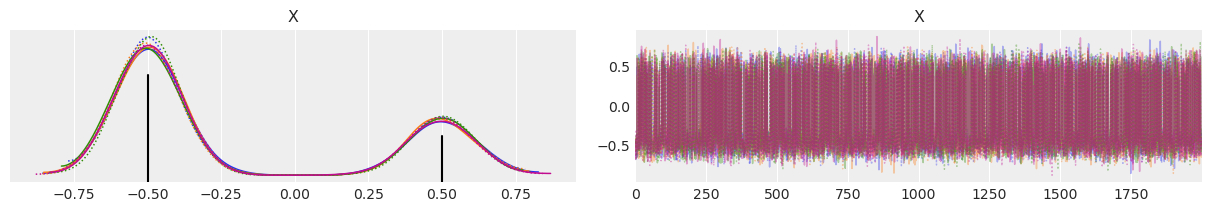

In [10]:
plt.figure()
ax = az.plot_trace(az_smc_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

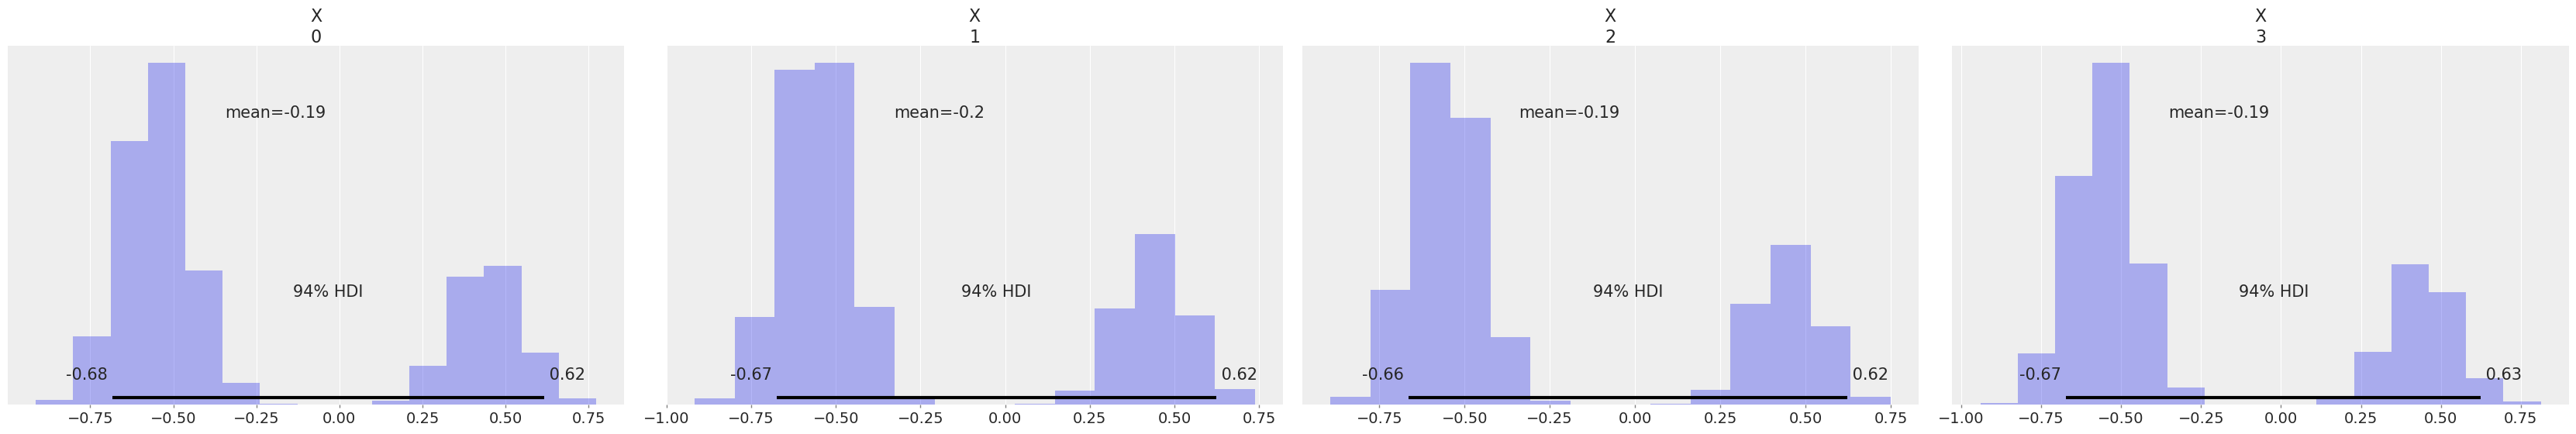

In [11]:
plt.figure()
az.plot_posterior(az_smc_trace, kind='hist')
plt.show()

Below I plot the X[0] posterior obtained from the NFMC and SMC runs. 

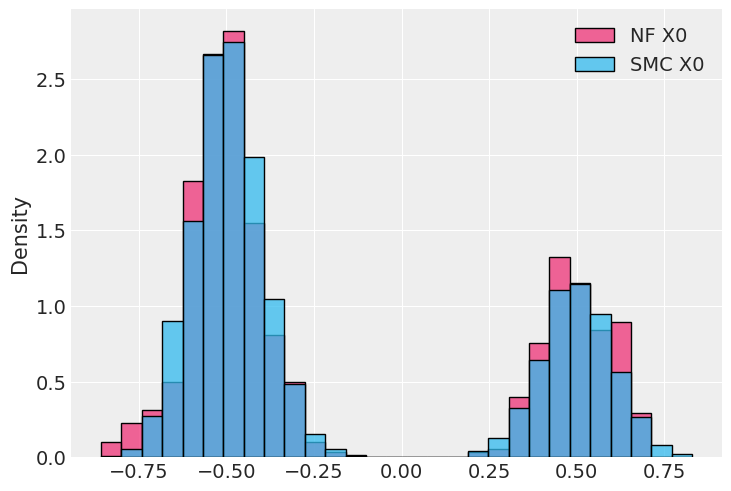

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


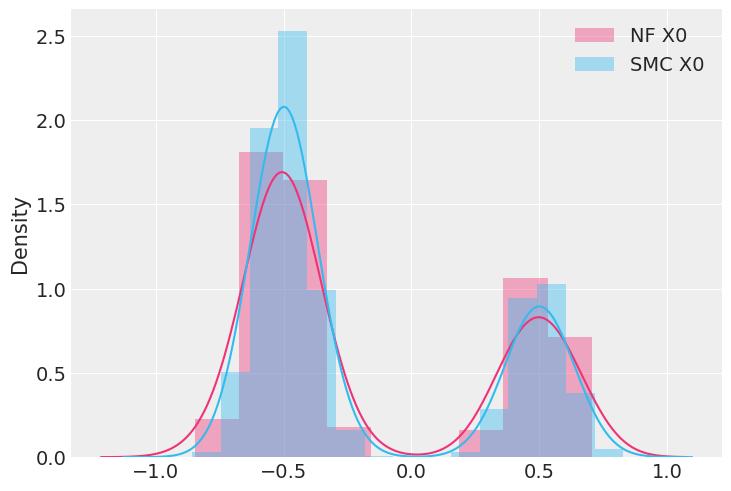

"\nplt.figure()\nsns.distplot(nf_x1, label='NF X1')\nsns.distplot(smc_x1, label='SMC X1')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x2, label='NF X2')\nsns.distplot(smc_x2, label='SMC X2')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x3, label='NF X3')\nsns.distplot(smc_x3, label='SMC X3')\nplt.legend(loc='upper right')\nplt.show()\n"

In [12]:
def marginal_two_gauss(x, mu1=0.5, mu2=-0.5, sigma=0.1):
    like1 = np.exp(-(x - mu1)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    like2 = np.exp(-(x - mu2)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    return w1 * like1 + w2 * like2

nf_df = az_trace.to_dataframe()
smc_df = az_smc_trace.to_dataframe()

nf_x0 = nf_df[('X[0]', 0)].to_numpy()
nf_x1 = nf_df[('X[1]', 1)].to_numpy()
nf_x2 = nf_df[('X[2]', 2)].to_numpy()
nf_x3 = nf_df[('X[3]', 3)].to_numpy()
smc_x0 = smc_df[('X[0]', 0)].to_numpy()
smc_x1 = smc_df[('X[1]', 1)].to_numpy()
smc_x2 = smc_df[('X[2]', 2)].to_numpy()
smc_x3 = smc_df[('X[3]', 3)].to_numpy()

x_vals = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 100)
y_vals = marginal_two_gauss(x_vals)

bins = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 30)
plt.figure()
sns.histplot(nf_x0, label='NF X0', bins=bins, stat='density', color='#EE3377')
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
#plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x0, label='NF X0', color='#EE3377')
sns.distplot(smc_x0, label='SMC X0', color='#33BBEE')
#plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

'''
plt.figure()
sns.distplot(nf_x1, label='NF X1')
sns.distplot(smc_x1, label='SMC X1')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x2, label='NF X2')
sns.distplot(smc_x2, label='SMC X2')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x3, label='NF X3')
sns.distplot(smc_x3, label='SMC X3')
plt.legend(loc='upper right')
plt.show()
'''

In [2]:
n = 100

mu1 = np.ones(n) * (1.0 / 2)

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

def gaussian(x):
    log_like = (
        -0.5 * n * tt.log(2 * np.pi)
        -0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    
    return log_like

with pm.Model() as model:

    X = pm.Uniform('X', lower=-2, upper=2, 
                   shape=n, testval=0.5 * np.ones_like(mu1)) 
    llk = pm.Potential("llk", gaussian(X))
    
with model:
    
    g2_start = {'X': mu1}
    g2_trace = pm.sample_nf_smc(5000, local_thresh=3, local_step_size=0.5, local_grad=True, nf_local_iter=10,
                                chains=1, frac_validate=0.2, alpha=(0,0), parallel=False, 
                                NBfirstlayer=True, bw_factor=2.0, k_trunc=0.5, pareto=False, 
                                iteration=5, max_line_search=20)
    g2_az_trace = az.from_pymc3(g2_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000


Number of points we perform additional local exploration around = 0
5000
Number of points we perform additional local exploration around = 334


Stage:   1 Beta: 0.002


5000
Number of points we perform additional local exploration around = 294


Stage:   2 Beta: 0.004


5000
Number of points we perform additional local exploration around = 38


Stage:   3 Beta: 0.023
Stage:   4 Beta: 1.000


5000
5000


/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarn

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarn

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarn

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/hom

array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'X'}>]], dtype=object)

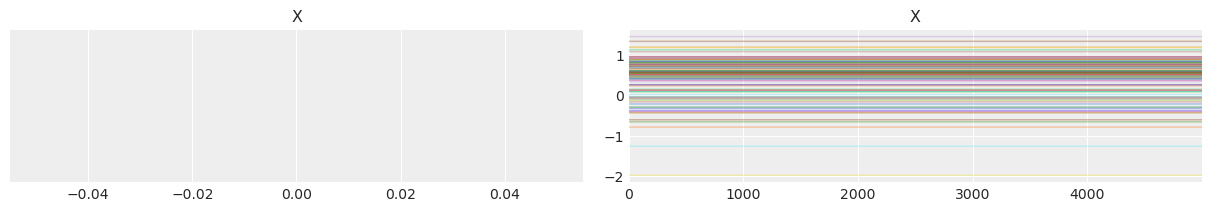

In [3]:
az.plot_trace(g2_az_trace)

# Ring example ...

In [3]:
a = 2
b = 1
n = 20

def ring(X):

    return -((X[-1]**2 + X[0]**2 - a)**2 / b)**2 - tt.sum(((X[:-1]**2 + X[1:]**2 - a)**2 / b)**2)
    
with pm.Model() as ring_model:

    X = pm.Uniform(
        "X",
        shape=n,
        lower=-5.0,
        upper=5.0,
        testval=1.0,
    )

    llk = pm.Potential("llk", ring(X))
    
    start = {'X': 1.2 * np.ones(n)}
    full_ring_trace = pm.sample_nf_smc(5000, local_thresh=3, local_step_size=0.5, local_grad=True, 
                                       nf_local_iter=40, chains=1, frac_validate=0.2, alpha=(0,0), 
                                       parallel=False, NBfirstlayer=True, bw_factor=2.0, k_trunc=0.5, 
                                       pareto=False, iteration=5, max_line_search=20)
    az_full_ring_trace = az.from_pymc3(full_ring_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


Number of points we perform additional local exploration around = 526


Stage:   0 Beta: 0.000


KeyboardInterrupt: 

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


<Figure size 720x480 with 0 Axes>

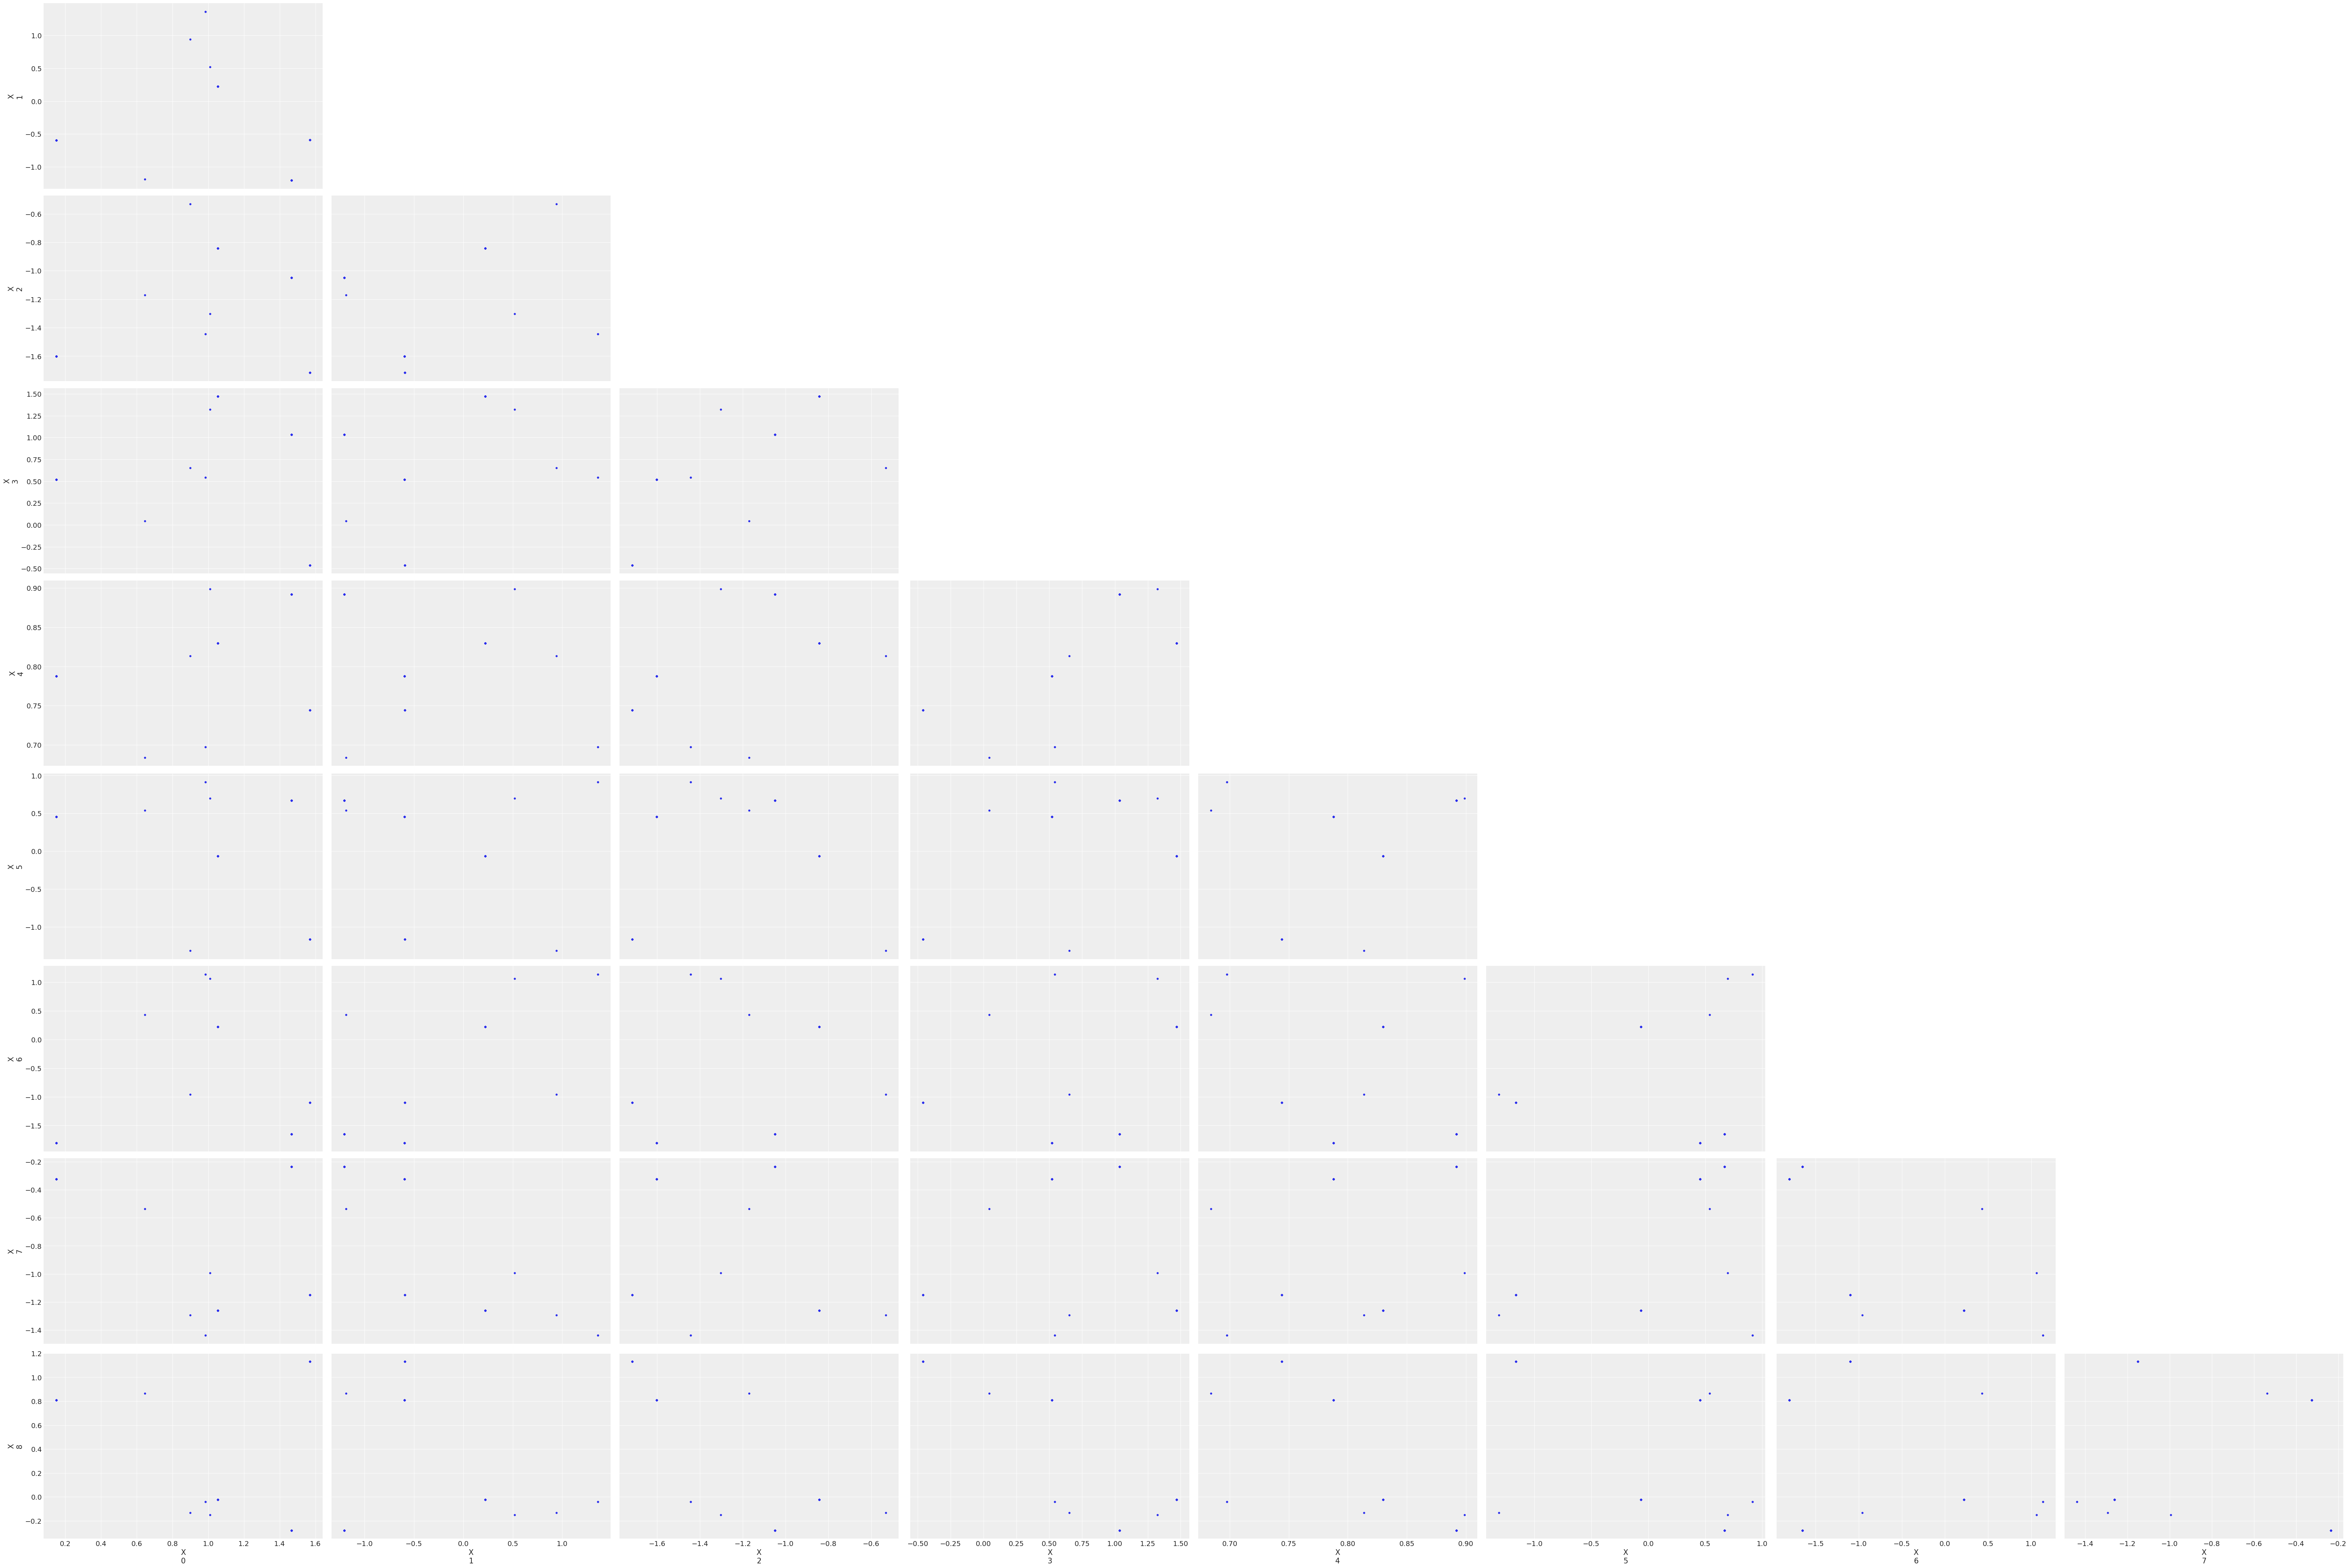

<Figure size 720x480 with 0 Axes>

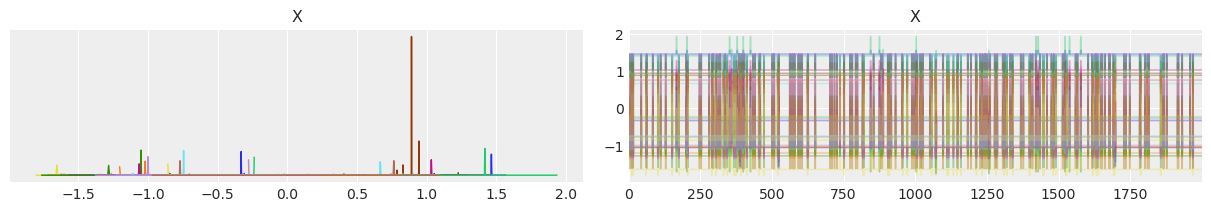

In [3]:
plt.figure()
az.plot_pair(az_full_ring_trace)
plt.show()

plt.figure()
az.plot_trace(az_full_ring_trace)
plt.show()

In [8]:
a = 2
b = 1
n = 4

def ring(X):

    return -((X[-1]**2 + X[0]**2 - a)**2 / b)**2 - tt.sum(((X[:-1]**2 + X[1:]**2 - a)**2 / b)**2)
    
with pm.Model() as ring_model:

    X = pm.Uniform(
        "X",
        shape=n,
        lower=-5.0,
        upper=5.0,
        testval=1.0,
    )

    llk = pm.Potential("llk", ring(X))
    
    start = {'X': 1.2 * np.ones(n)}
    full_ring_trace = pm.sample_nf_smc(2000, local_thresh=3, local_step_size=0.5, local_grad=True, 
                                       nf_local_iter=40, chains=1, frac_validate=0.2, alpha=(0,0), 
                                       parallel=False, NBfirstlayer=True, bw_factor=2.0, k_trunc=0.5, 
                                       pareto=True, iteration=5, max_line_search=20)
    az_full_ring_trace = az.from_pymc3(full_ring_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000


Number of points we perform additional local exploration around = 0


Stage:   1 Beta: 0.000


Number of points we perform additional local exploration around = 2
Number of points we perform additional local exploration around = 22


Stage:   2 Beta: 0.000


Number of points we perform additional local exploration around = 67


Stage:   3 Beta: 0.005


Number of points we perform additional local exploration around = 126


Stage:   4 Beta: 0.076


Number of points we perform additional local exploration around = 53


Stage:   5 Beta: 0.153


Number of points we perform additional local exploration around = 62


Stage:   6 Beta: 0.211


Number of points we perform additional local exploration around = 71


Stage:   7 Beta: 0.265


Number of points we perform additional local exploration around = 103


Stage:   8 Beta: 0.321


Number of points we perform additional local exploration around = 100


Stage:   9 Beta: 0.384


Number of points we perform additional local exploration around = 84


Stage:  10 Beta: 0.436


Number of points we perform additional local exploration around = 106


Stage:  11 Beta: 0.482


Number of points we perform additional local exploration around = 183


Stage:  12 Beta: 0.514


Number of points we perform additional local exploration around = 174


Stage:  13 Beta: 0.551


Number of points we perform additional local exploration around = 228


Stage:  14 Beta: 0.581


Number of points we perform additional local exploration around = 138


Stage:  15 Beta: 0.625


Number of points we perform additional local exploration around = 241


Stage:  16 Beta: 0.646


Number of points we perform additional local exploration around = 223


Stage:  17 Beta: 0.680


Number of points we perform additional local exploration around = 233


Stage:  18 Beta: 0.720


Number of points we perform additional local exploration around = 224


Stage:  19 Beta: 0.754


Number of points we perform additional local exploration around = 240


Stage:  20 Beta: 0.779


Number of points we perform additional local exploration around = 234


Stage:  21 Beta: 0.817


Number of points we perform additional local exploration around = 261


Stage:  22 Beta: 0.847


Number of points we perform additional local exploration around = 178


Stage:  23 Beta: 0.884


Number of points we perform additional local exploration around = 272


Stage:  24 Beta: 0.908


Number of points we perform additional local exploration around = 284


Stage:  25 Beta: 0.941


Number of points we perform additional local exploration around = 222


Stage:  26 Beta: 0.985
Stage:  27 Beta: 1.000


<Figure size 720x480 with 0 Axes>

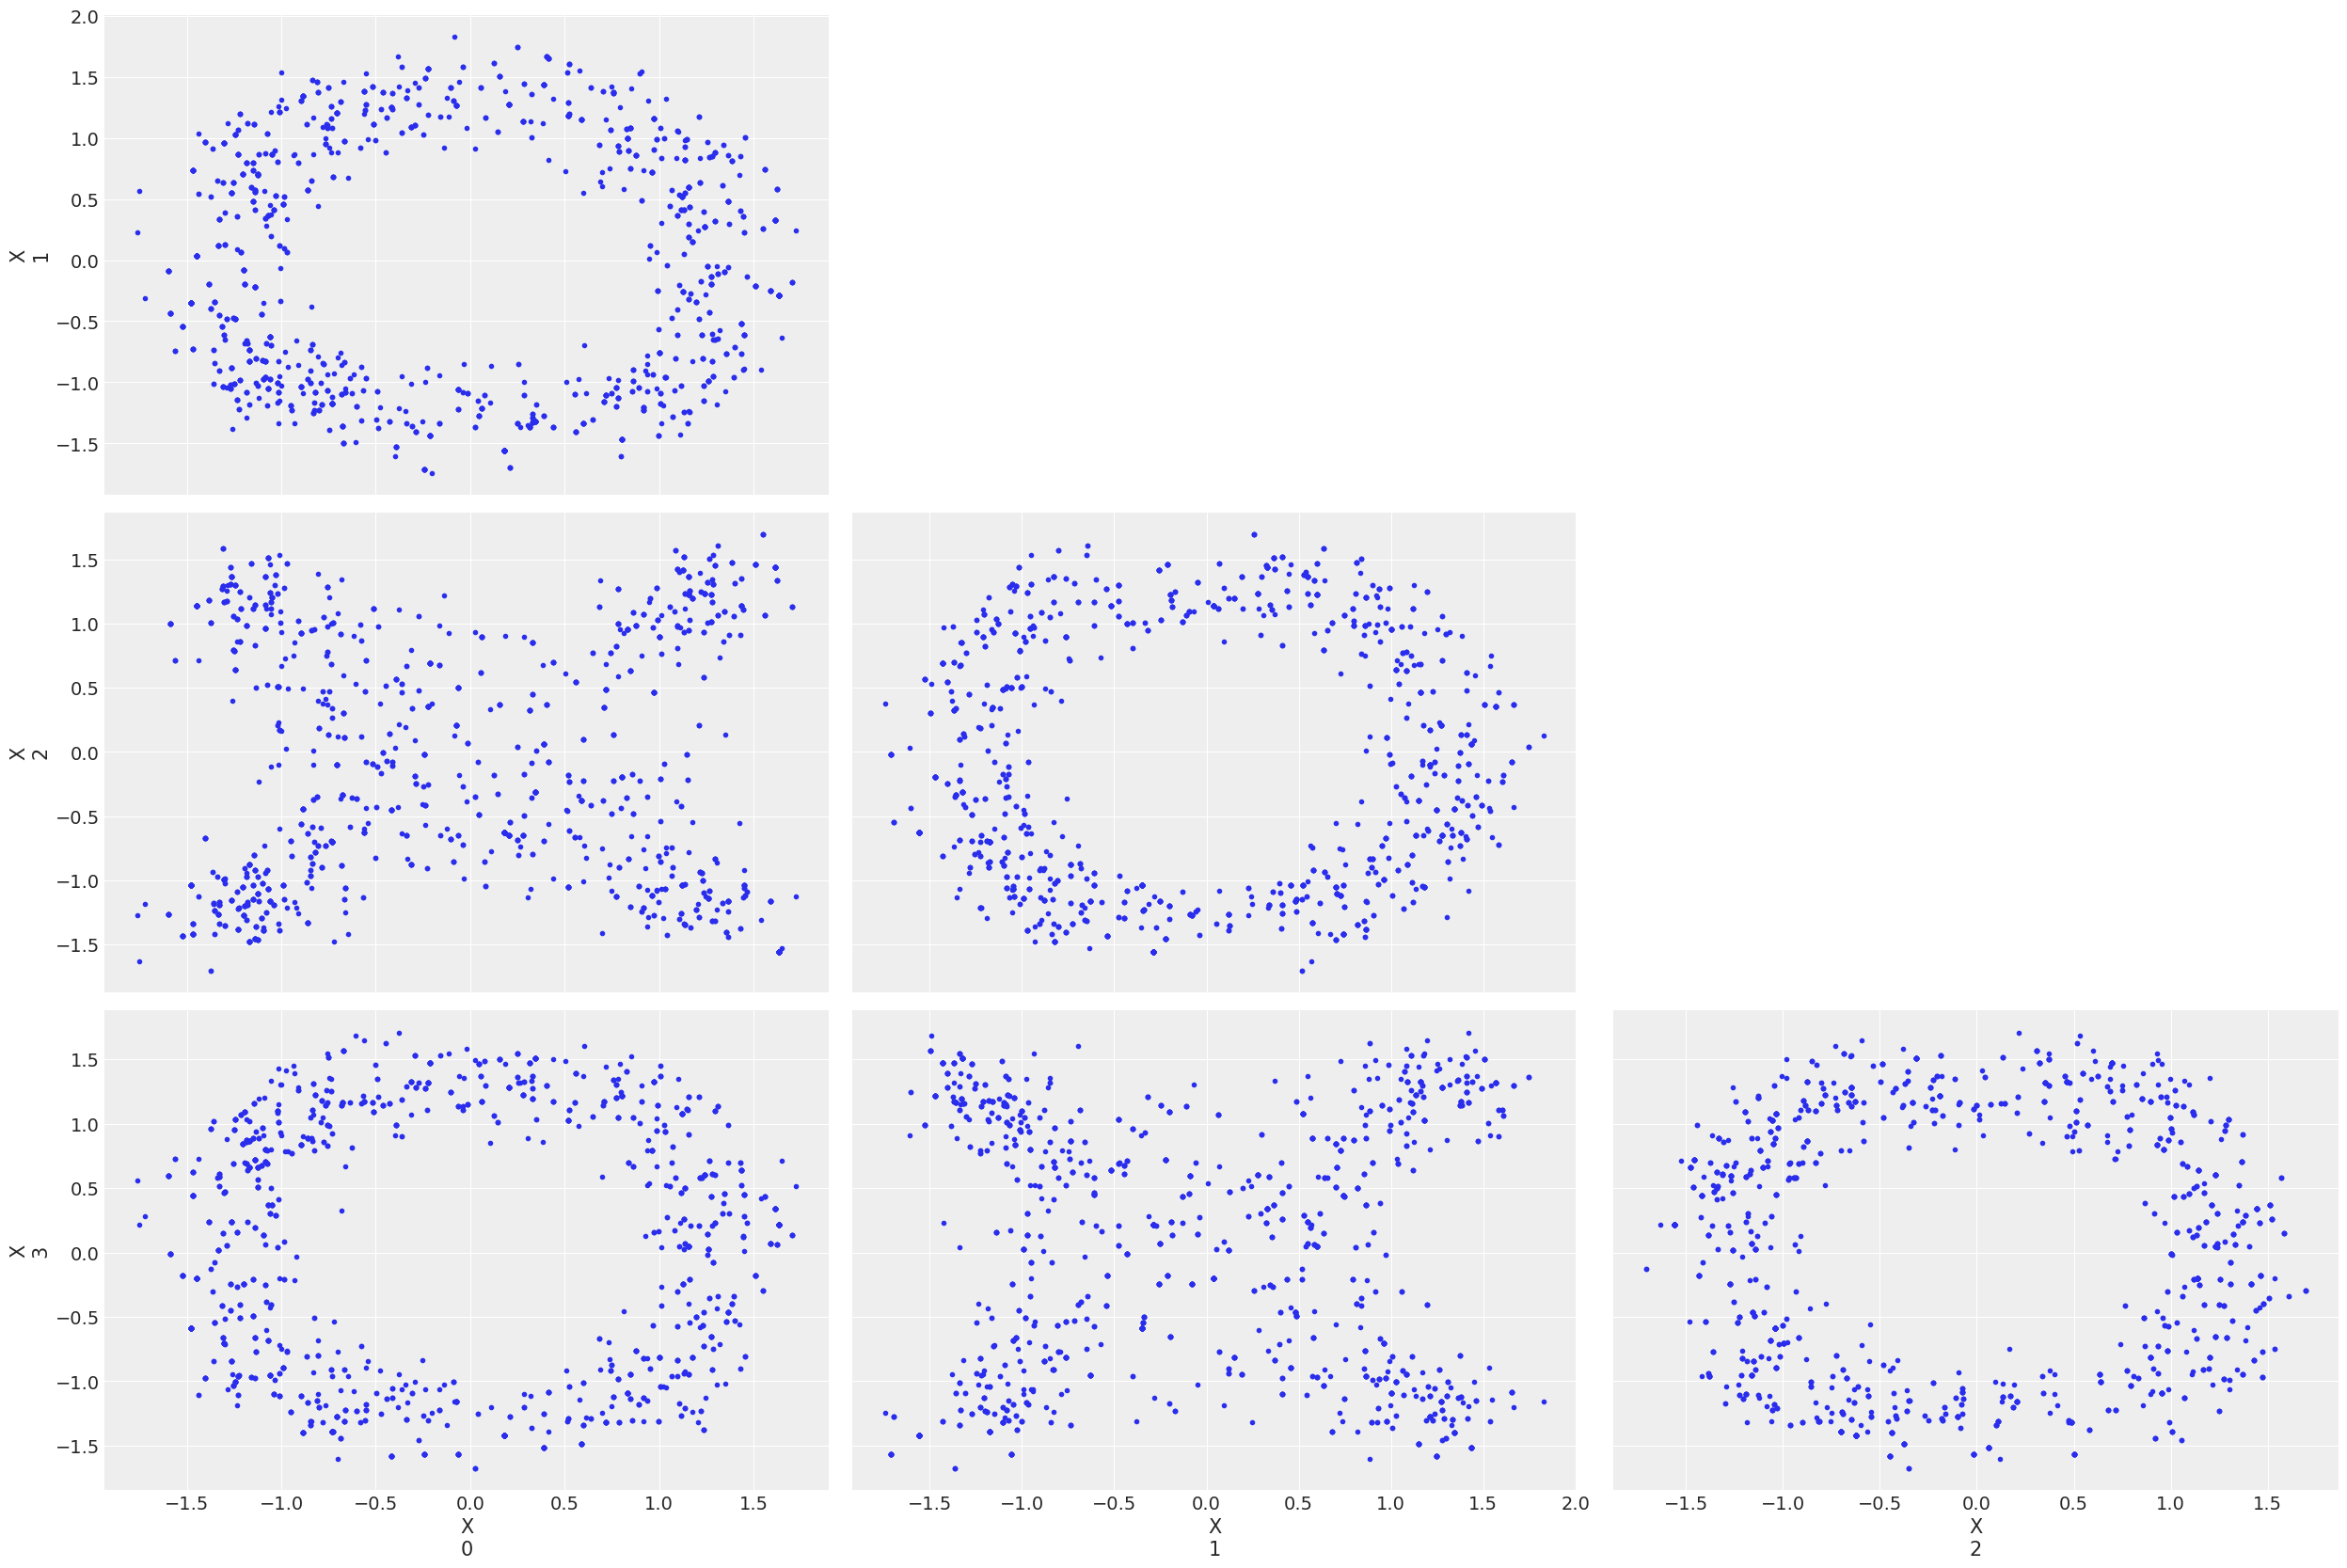

<Figure size 720x480 with 0 Axes>

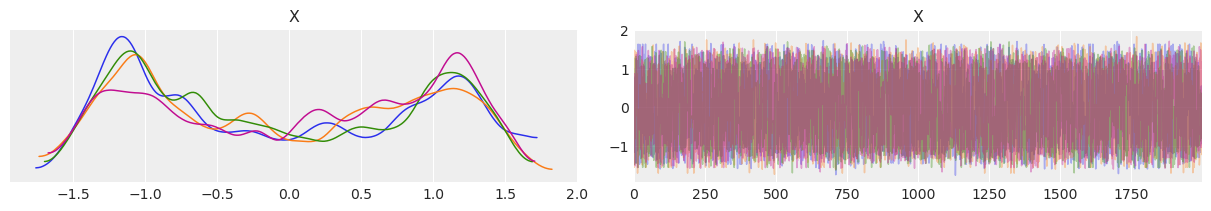

In [9]:
plt.figure()
az.plot_pair(az_full_ring_trace)
plt.show()

plt.figure()
az.plot_trace(az_full_ring_trace)
plt.show()

# Correlated Gaussian

In [5]:
n = 10

# Draw precision matrix from the Wishart distribution, with n degrees of freedom and identity scale.
wish = scipy.stats.wishart(df=n, scale=np.eye(n))
A = wish.rvs()
detA = np.linalg.det(A)
print(A)
print(detA)

def gaussian(x):
    log_like = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(detA)
        - 0.5 * (x).T.dot(A).dot(x)
    )
    
    return log_like

with pm.Model() as model:
    
    X = pm.Uniform('X', lower=-10, upper=10, shape=n, testval=0)
    llk = pm.Potential("llk", gaussian(X))
    
with model:
    
    g_start = {'X': np.zeros(n)}
    g_trace = pm.sample_nf_smc(2000, local_thresh=3, local_step_size=0.5, local_grad=True, 
                               nf_local_iter=40, chains=1, frac_validate=0.2, alpha=(0,0), 
                               parallel=False, NBfirstlayer=True, bw_factor=2.0, k_trunc=0.5, 
                               pareto=True, iteration=5, max_line_search=20)
    g_az_trace = az.from_pymc3(g_trace)

[[ 8.49964174 -2.60285373 -0.14044333  3.92935856 -0.72980181 -0.68274234
  -2.20097532  1.49253542  0.6588919  -2.82474985]
 [-2.60285373  9.29780047 -2.26075184 -2.13607162  6.21028597 -0.8400098
  -2.78229393 -2.71826413  2.6095809  -0.84975978]
 [-0.14044333 -2.26075184 19.16156553  3.43865053 -0.35572886 -0.31988598
  -4.93717177 -8.88686475  7.20250153 -4.20578264]
 [ 3.92935856 -2.13607162  3.43865053 22.83658502  1.62682922 12.50266639
  -3.35474349  0.90381842  1.31425891 -5.89518602]
 [-0.72980181  6.21028597 -0.35572886  1.62682922 13.95836263  0.5373711
  -6.21058211 -1.66741428  0.96511629 -2.57791754]
 [-0.68274234 -0.8400098  -0.31988598 12.50266639  0.5373711   9.95093454
  -0.10777039  1.09798685 -1.42724779 -3.49172571]
 [-2.20097532 -2.78229393 -4.93717177 -3.35474349 -6.21058211 -0.10777039
   6.0454255   2.6678761  -3.04960824  4.18902083]
 [ 1.49253542 -2.71826413 -8.88686475  0.90381842 -1.66741428  1.09798685
   2.6678761   7.15026739 -5.03603303  1.44052009]
 [

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000


Number of points we perform additional local exploration around = 0
Number of points we perform additional local exploration around = 126


Stage:   1 Beta: 0.001


Number of points we perform additional local exploration around = 144


Stage:   2 Beta: 0.004


Number of points we perform additional local exploration around = 172


Stage:   3 Beta: 0.014


Number of points we perform additional local exploration around = 124


Stage:   4 Beta: 0.026


Number of points we perform additional local exploration around = 152


Stage:   5 Beta: 0.040


Number of points we perform additional local exploration around = 149


Stage:   6 Beta: 0.075


Number of points we perform additional local exploration around = 158


Stage:   7 Beta: 0.115


Number of points we perform additional local exploration around = 154


Stage:   8 Beta: 0.205


Number of points we perform additional local exploration around = 153


Stage:   9 Beta: 0.354


Number of points we perform additional local exploration around = 153


Stage:  10 Beta: 0.625
Stage:  11 Beta: 1.000


/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


<Figure size 720x480 with 0 Axes>

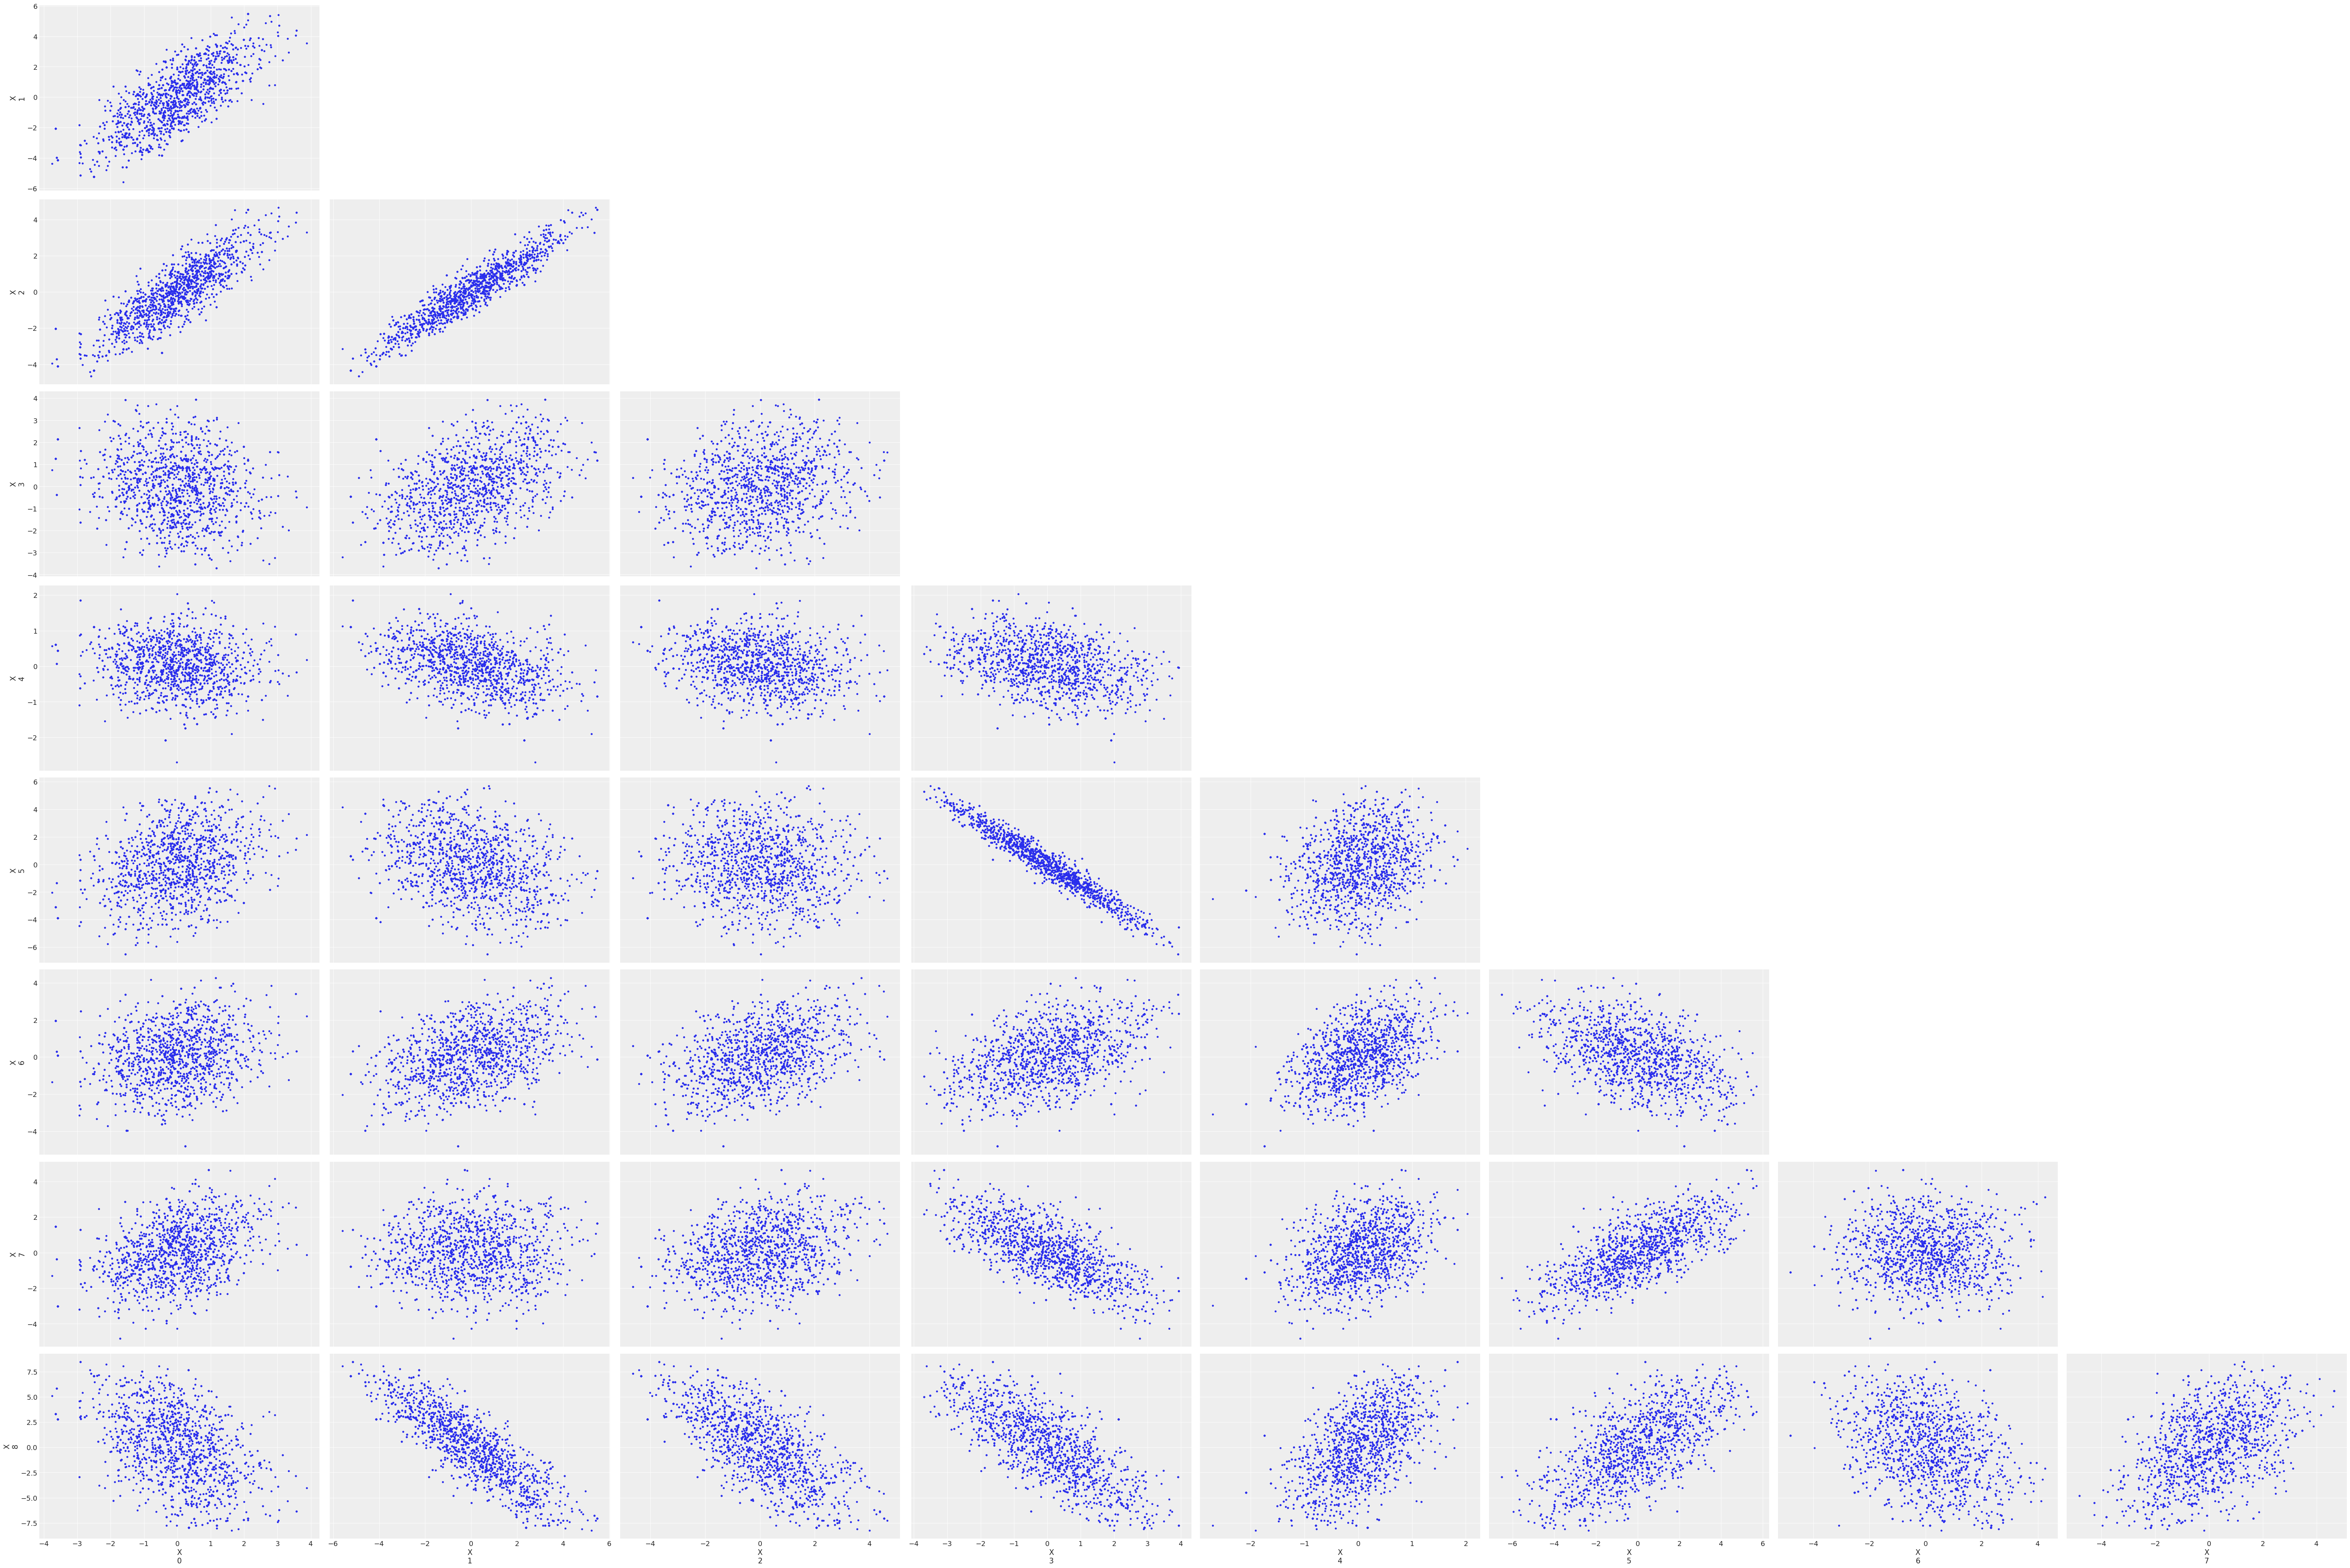

<Figure size 720x480 with 0 Axes>

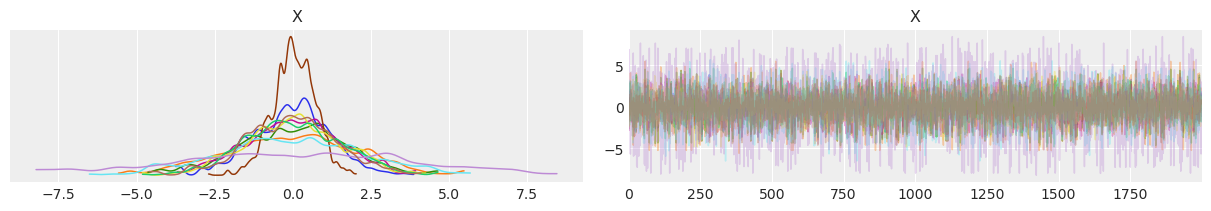

In [7]:
plt.figure()
az.plot_pair(g_az_trace)
plt.show()

plt.figure()
az.plot_trace(g_az_trace)
plt.show()

# Regression example ...

In [20]:
rg_model = pm.Model()
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1)

with rg_model:

    a = pm.Normal('a', mu=2, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)

    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    rg_trace = pm.sample_nf_smc(3000, local_thresh=3, local_step_size=0.5, local_grad=True, nf_local_iter=40,
                                chains=1, frac_validate=0.2, alpha=(0,0), parallel=False, 
                                NBfirstlayer=True, bw_factor=2.0, k_trunc=0.5, pareto=True, 
                                iteration=5, max_line_search=20)
    rg_az_trace = az.from_pymc3(rg_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000


Number of points we perform additional local exploration around = 0


Stage:   1 Beta: 0.000


Number of points we perform additional local exploration around = 7
Number of points we perform additional local exploration around = 67


Stage:   2 Beta: 0.002


Number of points we perform additional local exploration around = 134


Stage:   3 Beta: 0.009


Number of points we perform additional local exploration around = 206


Stage:   4 Beta: 0.044


Number of points we perform additional local exploration around = 113


Stage:   5 Beta: 0.145


Number of points we perform additional local exploration around = 148


Stage:   6 Beta: 0.551
Stage:   7 Beta: 1.000


<Figure size 720x480 with 0 Axes>

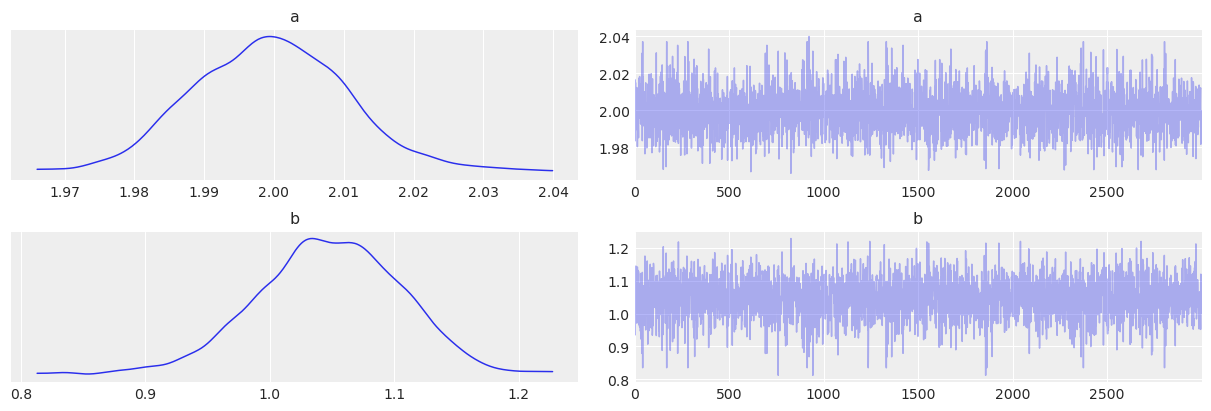

In [21]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

In [22]:
with rg_model:
    nuts_trace = pm.sample(2000)
    nuts_az_trace = az.from_pymc3(nuts_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


<Figure size 720x480 with 0 Axes>

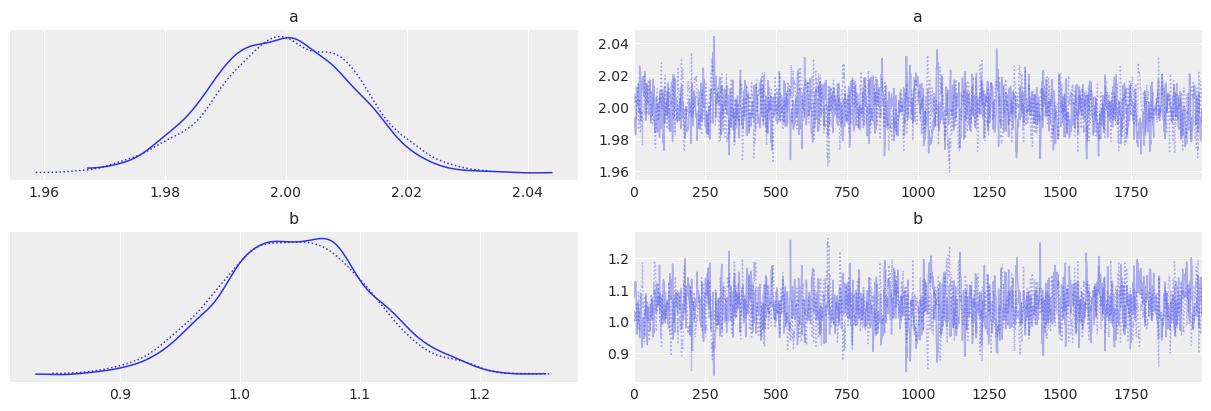

In [23]:
plt.figure()
ax = az.plot_trace(nuts_az_trace)
plt.show()

Hierarchical Radon Model ....

In [5]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [6]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

First, let's sample the posterior using NUTS.

In [6]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)
    hierarchical_az_trace = az.from_pymc3(hierarchical_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 298 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.774077840116966, but should be close to 0.9. Try to increase the number of tuning steps.
There were 383 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 720x480 with 0 Axes>

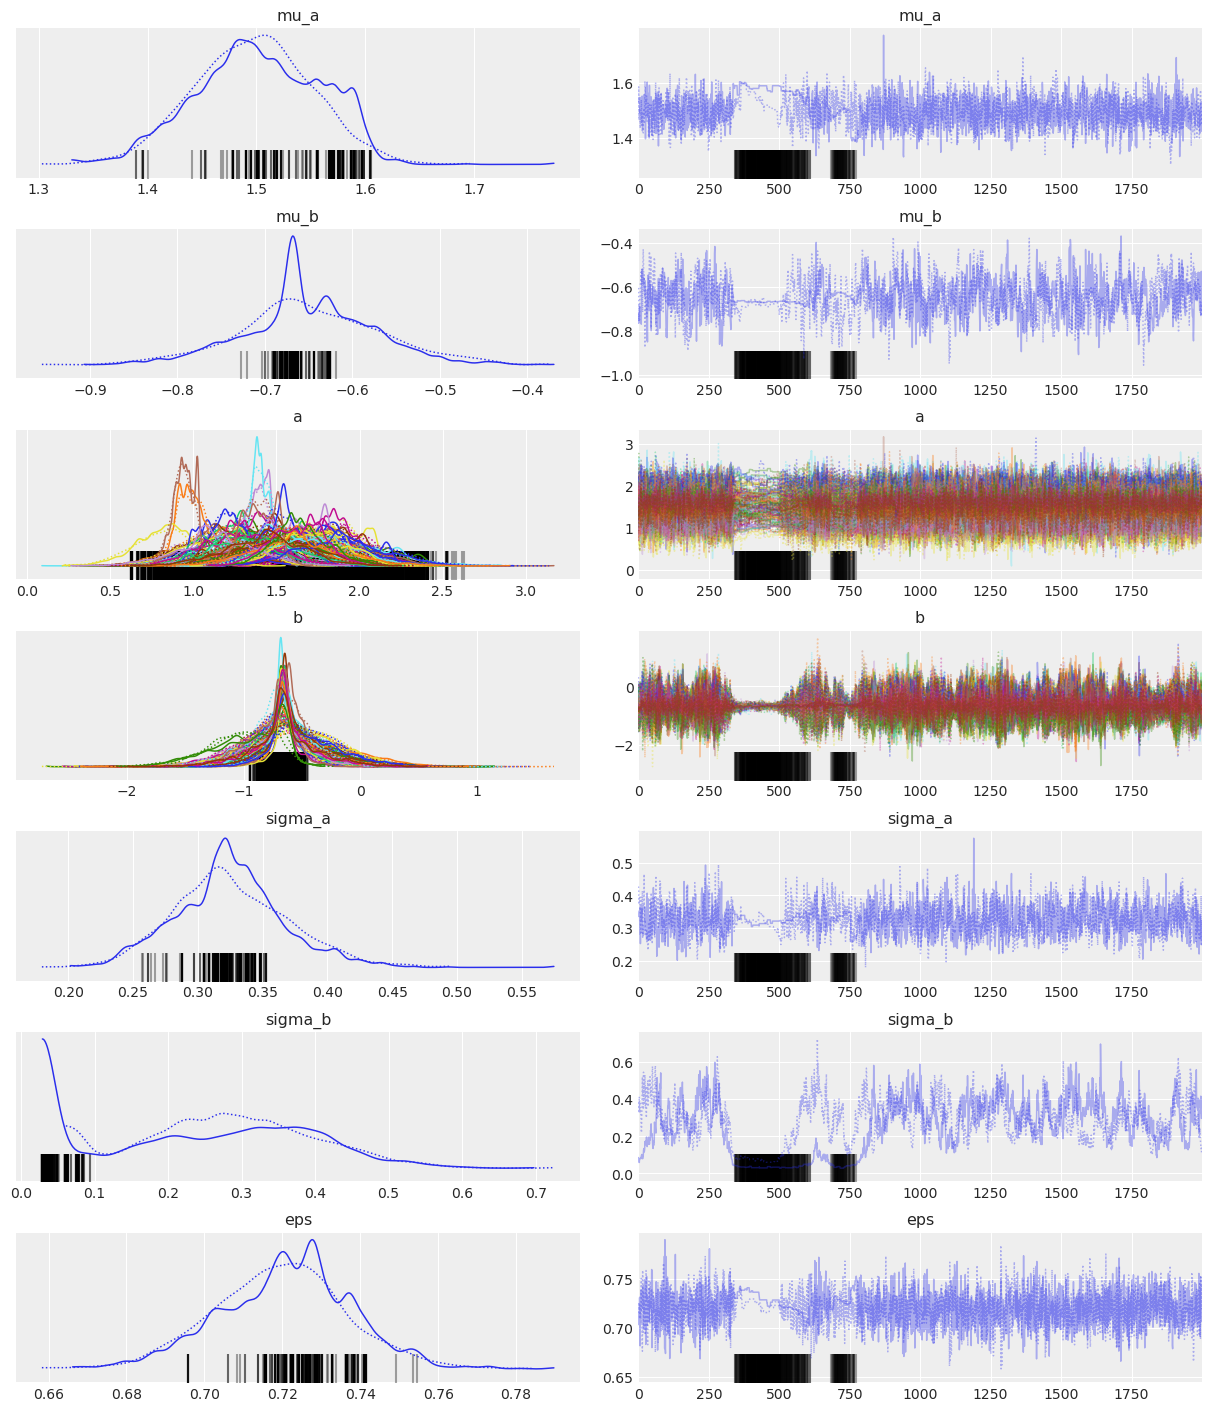

In [7]:
plt.figure()
ax = az.plot_trace(hierarchical_az_trace)
plt.show()

Now let's look at using NFMC.

In [7]:
with hierarchical_model:
    hierarchical_nf_trace = pm.sample_nf_smc(2000, local_thresh=3, local_step_size=0.5, local_grad=True, 
                                             nf_local_iter=40, chains=1, frac_validate=0.2, alpha=(0,0), 
                                             parallel=False, NBfirstlayer=True, bw_factor=2.0, k_trunc=0.5, 
                                             pareto=True, iteration=5, max_line_search=20)
    hierarchical_az_nf_trace = az.from_pymc3(hierarchical_nf_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/theano/gradient.py:624: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: sigma_b_log__ ~ TransformedDistribution
  handle_disconnected(elem)
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/theano/gradient.py:650: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a non-differentiable operator: <DisconnectedType>
  handle_disconnected(rval[i])
/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/theano/gradient.py:624: UserWarning: grad method was asked to compute the gradient with respect to a variable that is not part of the computational graph of the cost, or is used only by a 

Number of points we perform additional local exploration around = 0


/home/richard/pymc3_dev/pymc3/nf_smc/nf_smc.py:310: RuntimeWarning: overflow encountered in exp
  ESS = int(np.exp(-logsumexp(log_weights_q + log_weights * 2)) / self.draws)


Number of points we perform additional local exploration around = 1


/home/richard/pymc3_dev/pymc3/nf_smc/nf_smc.py:267: RuntimeWarning: divide by zero encountered in log
  local_log_w = self.high_log_weight[i] + self.tempered_logp(proposed_step) - np.log(np.exp(self.tempered_logp(proposed_step)) + np.exp(self.tempered_logp(sample)))
/home/richard/pymc3_dev/pymc3/nf_smc/nf_smc.py:268: RuntimeWarning: divide by zero encountered in log
  modif_log_w = self.high_log_weight[i] + self.tempered_logp(sample) - np.log(np.exp(self.tempered_logp(proposed_step)) + np.exp(self.tempered_logp(sample)))
Stage:   1 Beta: 0.069


ValueError: cannot convert float NaN to integer

In [ ]:
optim_iter=1000, nf_iter=20, 